In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [148]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [149]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [150]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [151]:
def add_day(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    
    return True

def add_hour(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    )
    
    return True

In [152]:
add_day(raw_df)
add_hour(raw_df)

True

In [153]:
# группировка по днм недели
def transaction_by_day_count(dataset):
    
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
# группировка по времени суток

def transaction_by_hour_count(dataset):
    
    tmp_df = dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['hour_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'hour_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df



In [154]:
import requests

In [155]:
# спарсим курс валют
class Rate:
    def __init__(self, format='value'):
        self.format = format
    
    def exchange_rates(self):
        """
        Возвращает ответ сервиса с информацией о валютах в виде:
        
        {
            'AMD': {
                'CharCode': 'AMD',
                'ID': 'R01060',
                'Name': 'Армянских драмов',
                'Nominal': 100,
                'NumCode': '051',
                'Previous': 14.103,
                'Value': 14.0879
                },
            ...
        }
        """
        r = requests.get('https://www.cbr-xml-daily.ru/daily_json.js')
        return r.json()['Valute']

In [156]:
r = Rate()
rates = r.exchange_rates()

currency_list = list(
    map(
        lambda x: (rates[x]['NumCode'], rates[x]['Name'], rates[x]['Value']/rates[x]['Nominal']), rates
    )
)


df_currency = pd.DataFrame(currency_list)
df_currency.columns = ['numcode','currency_name','rate']

# не хватало российского рубля
df_currency = df_currency.append({'numcode':'810', 'currency_name':'Российский рубль', 'rate':'1'}, ignore_index=True)

df_currency.numcode = df_currency.numcode.astype(int)
df_currency.index = df_currency.numcode

df_currency = df_currency.drop('numcode', axis = 1)

In [157]:
raw_df['currency_rate']=raw_df.currency.map(df_currency.rate)

raw_df.currency_rate = raw_df.currency_rate.astype(float)
raw_df['amount_rub'] = raw_df['amount']*raw_df['currency_rate']

In [158]:
raw_df.shape

(490513, 14)

In [159]:
# Пример загрузки описаний MCC кодов

from bs4 import BeautifulSoup as bs
# import requests
import urllib
from urllib.request import urlopen, Request

In [160]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'
}
reg_url = 'https://mcc-codes.ru/code'
req = Request(url=reg_url, headers=headers)

In [161]:
check = bs(urlopen(req).read())

/Users/olgamonahova/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/olgamonahova/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [162]:
list_of_mcc_tags = check.find_all('tr')[1:]

In [163]:
mcc_names_list = list(
    map(
        lambda x: (x.text.split('\n')[1], x.text.split('\n')[2]), list_of_mcc_tags
    )
)

In [164]:
df_mcc_list = pd.DataFrame(mcc_names_list)

In [165]:
df_mcc_list.index = df_mcc_list[0].astype('int')
df_mcc_list = df_mcc_list.drop(df_mcc_list.columns[-2], axis = 1)
df_mcc_list.rename(columns={1: 'MCC_definition'}, inplace=True)

In [166]:
df_mcc_list.head()

,MCC_definition
0,
742,Ветеринарные услуги
763,Сельскохозяйственные кооперативы
780,Услуги садоводства и ландшафтного дизайна
1520,Генеральные подрядчики – жилое и коммерческое ...
1711,"Генеральные подрядчики по вентиляции, теплосна..."


In [167]:
raw_df.shape

(490513, 14)

In [168]:
raw_df['MCC_definition']=raw_df.MCC.map(df_mcc_list.MCC_definition) 

In [169]:
raw_df.MCC_definition.value_counts().head(15)

Бакалейные магазины, супермаркеты                                           121640
Финансовые учреждения – снятие наличности автоматически                      54382
Фастфуд                                                                      41351
Места общественного питания, рестораны                                       30027
Различные продовольственные магазины - нигде более не классифицированные     27237
Станции техобслуживания, с дополнительными услугами или без                  19816
Аптеки                                                                       18728
Различные магазины и специальные розничные магазины                          13073
Финансовые учреждения – торговля и услуги                                    10056
Магазины с продажей спиртных напитков навынос                                 8578
Универсальные магазины                                                        7641
Лимузины и такси                                                              6266
Лесо

Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [170]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [171]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  392630
Total transactions in test dataset:  97883


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ceb9780>,
      dtype=object)

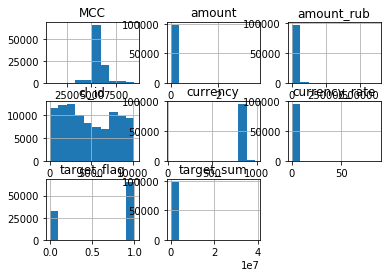

In [172]:
transactions_test.hist()

In [173]:
grouped_MCC = transactions_train[
    ['MCC', 'amount_rub']].groupby(['MCC']).agg(['sum'])

In [174]:
# найдем 50 основных категорий с максимальным оборотом
TOP_MCC_amount = pd.DataFrame(grouped_MCC.sort_values(by=grouped_MCC.columns[0], ascending = False).head(50))


In [175]:
# оставим 50 главных MCC по суммам, остальные определим в Others
def MCC_in_top(row):
    if row['MCC'] in TOP_MCC_amount.index:
        return row['MCC']
    else:
        return 'Other'

In [176]:
transactions_train['MCC_top'] = transactions_train.apply(MCC_in_top, axis = 1)
transactions_test['MCC_top'] = transactions_test.apply(MCC_in_top, axis = 1)

In [177]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount_rub']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [178]:
# разобьем по МСС обучающую выборку
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC_top'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC_top'),
    left_index=True,
    right_index=True,
)

In [179]:
# повторим для тестовой выборки
df_test_mcc = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='MCC_top'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='MCC_top'),
    left_index=True,
    right_index=True,
)

In [180]:
transactions_train.shape

(392630, 16)

In [181]:
df_train_mcc.shape

(4000, 102)

In [182]:
df_test_mcc.shape

(1000, 102)

In [183]:
TRX = transactions_train[
    ['trx_category', 'amount_rub']
].groupby(['trx_category']).agg(['sum'])
   

In [184]:
TRX.columns = TRX.columns.droplevel()

In [185]:
TRX

,sum
trx_category,
BACK_TRX,1.912556e+07
C2C_IN,8.264083e+07
C2C_OUT,7.422869e+07
CASH_ADV,6.961970e+05
CAT,1.720097e+07
DEPOSIT,3.868461e+08
POS,7.043291e+08
WD_ATM_OTHER,4.139529e+07
WD_ATM_PARTNER,2.662376e+08


In [186]:
TRX = TRX.sort_values(by=TRX.columns[0], ascending = False)

In [187]:
def barplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots(figsize=(20,10))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
   
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title) 
  

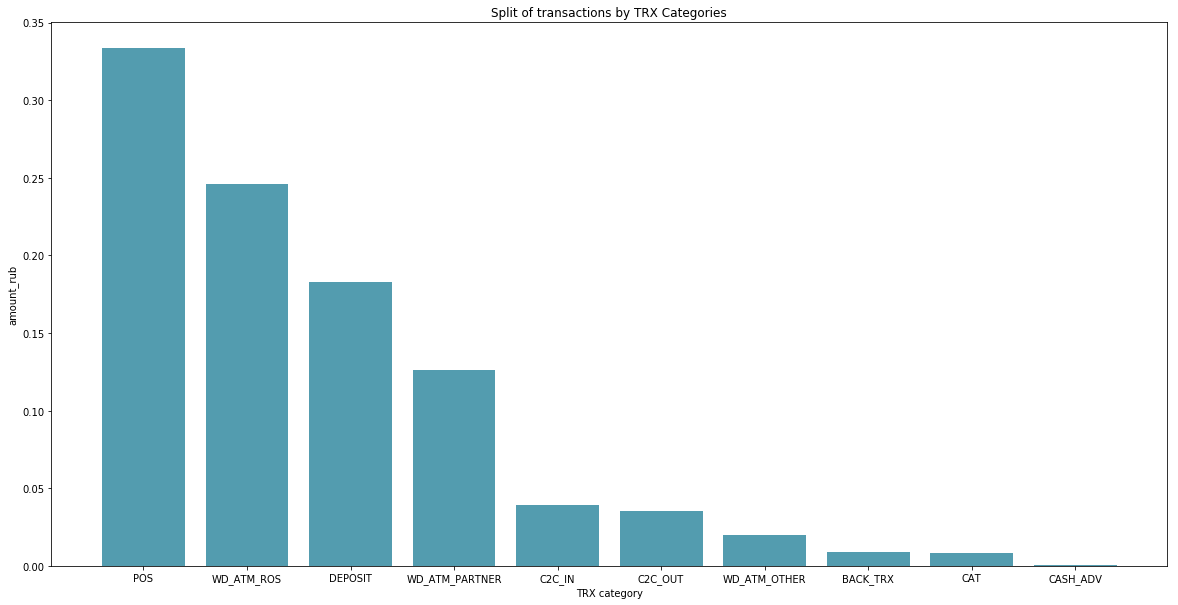

In [188]:
# распределение по категориям TRX категории: немного больше 1/3 транзакций приходится на снятие в бакноматах (все ATM), 1/3  - на оплату товаров и услуг (POS),
barplot(TRX.index, TRX['sum']/TRX.sum()[0], 'TRX category', 'amount_rub', 'Split of transactions by TRX Categories')


In [189]:
df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

In [190]:
df_train_trx_category.shape

(4000, 20)

In [191]:
df_test_trx_category = pd.merge(
    get_aggregated_df(transactions_test, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_test, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_test_trx_category.shape

(1000, 20)

In [192]:
#Cl_Id list for train

df_train_targets = transactions_train[['cl_id', 'target_flag']].drop_duplicates().copy()
df_train_targets.index = df_train_targets['cl_id']
df_train_targets = df_train_targets.drop('cl_id', axis=1)
df_train_targets.shape

(4000, 1)

In [193]:
#Cl_Id list for test

df_test_targets = transactions_test[['cl_id', 'target_flag']].drop_duplicates().copy()
df_test_targets.index = df_test_targets['cl_id']
df_test_targets = df_test_targets.drop('cl_id', axis=1)
df_test_targets.shape

(1000, 1)

In [194]:
# признаки по часам
df_train_hour = transaction_by_hour_count(transactions_train)
df_train_hour.index = df_train_hour['cl_id']
df_train_hour = df_train_hour.drop('cl_id', axis=1)
df_train_hour.shape

(4000, 24)

In [195]:
df_test_hour = transaction_by_hour_count(transactions_test)
df_test_hour.index = df_test_hour['cl_id']
df_test_hour = df_test_hour.drop('cl_id', axis=1)
df_test_hour.shape

(1000, 24)

In [196]:
df_train_day = transaction_by_day_count(transactions_train)
df_train_day.index = df_train_day['cl_id']
df_train_day = df_train_day.drop('cl_id', axis=1)
df_train_day.shape


(4000, 7)

In [197]:
df_test_day = transaction_by_day_count(transactions_test)
df_test_day.index = df_test_day['cl_id']
df_test_day = df_test_day.drop('cl_id', axis=1)
df_test_day.shape

(1000, 7)

In [198]:
df_train= pd.merge(
    df_train_targets,
    df_train_trx_category,
    left_index=True,
    right_index=True,
)


df_train= pd.merge(
    df_train,
    df_train_mcc,
    left_index=True,
    right_index=True,
)


df_train= pd.merge(
    df_train,
    df_train_day,
    left_index=True,
    right_index=True,
)

df_train= pd.merge(
    df_train,
    df_train_hour,
    left_index=True,
    right_index=True,
)


df_train.shape


(4000, 154)

In [199]:
df_test= pd.merge(
    df_test_targets,
    df_test_trx_category,
    left_index=True,
    right_index=True,
)


df_test= pd.merge(
    df_test,
    df_test_mcc,
    left_index=True,
    right_index=True,
)


df_test= pd.merge(
    df_test,
    df_test_day,
    left_index=True,
    right_index=True,
)

df_test= pd.merge(
    df_test,
    df_test_hour,
    left_index=True,
    right_index=True,
)

df_test.shape


(1000, 154)

In [200]:
day = transactions_train[['day_of_transaction','amount_rub']].groupby(['day_of_transaction']).agg(['sum','count'])
day.sort_values(by=day.columns[0], ascending = False)
day.columns = day.columns.droplevel()
day.columns = ['amount_sum','amount_count']


In [201]:
def barplot(x_data, y_data, x_label="", y_label="", title=""):
    _, ax = plt.subplots()
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
   
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

In [202]:
week = ['Sun','Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat']

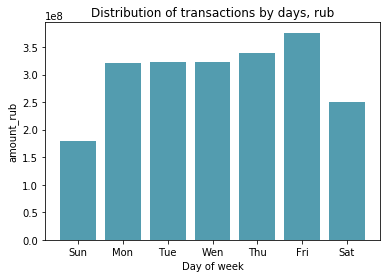

In [203]:
# основные крупные траты происходят в будние дни
barplot(week, day['amount_sum'], 'Day of week', 'amount_rub', 'Distribution of transactions by days, rub')

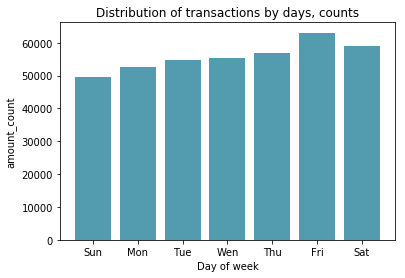

In [204]:
# на выходных количество транзакций почти без изменений, но средняя сумма значительно ниже из-за более мелких трат
barplot(week, day['amount_count'], 'Day of week', 'amount_count', 'Distribution of transactions by days, counts')

In [205]:
hour = transactions_train[['hour_of_transaction','amount_rub']].groupby(['hour_of_transaction']).agg(['sum','count'])
hour.columns = hour.columns.droplevel()
hour.columns = ['amount_sum','amount_count']

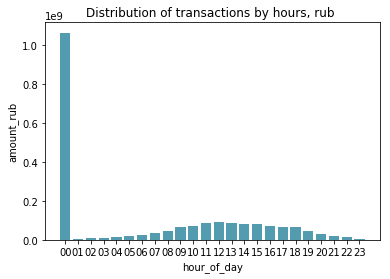

In [206]:
# есть подозрение, что большая часть транзакций - это автоматическое списание денежных средств с карты, 
#т.к. пик приходится на период с 0 до 1 часу ночи
# в рабочее время траты преобладают
barplot(hour.index, hour['amount_sum'], 'hour_of_day', 'amount_rub', 'Distribution of transactions by hours, rub ')

In [233]:
from sklearn.linear_model import LogisticRegression

In [231]:
clf = LogisticRegression()
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

In [232]:
clf.fit(X=X_train, y=y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [373]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.8


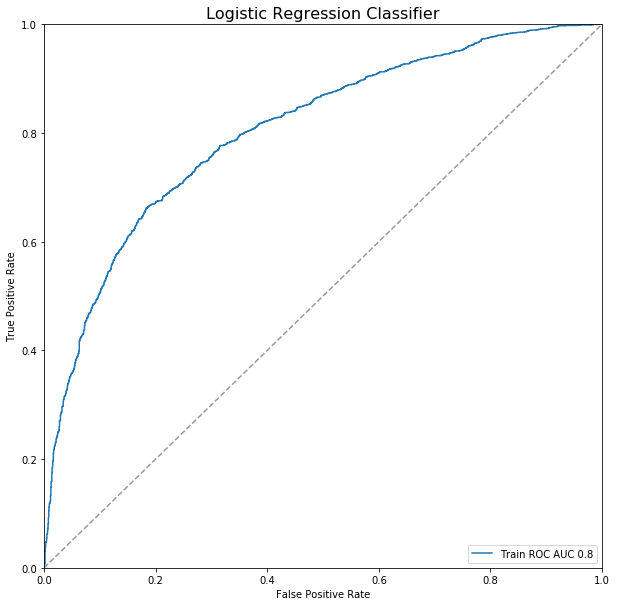

In [374]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()